# DETECTR 007 Analysis
This notebook is for formatting, analyzing and plotting the DETECTR_010 data. 

## Objective
Test the LOD when having a human genomic background

## Formatting to CSV file
Take txt file from plate reader and turn into tidy data format

In [1]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

import holoviews as hv
import bokeh
import hvplot.pandas

ModuleNotFoundError: No module named 'holoviews'

In [2]:
#read in CSV file
DETECTR_raw = pd.read_csv("../raw_txt_files/DETECTR_007.txt", encoding='utf-16', sep="\t", delimiter="\t",index_col=None, skiprows= 3,header = None)

In [7]:
#drop empty columns - we only had samples in the 2 and 3 columns of the plate
DETECTR_raw = DETECTR_raw.drop(list(range(14,len(DETECTR_raw.columns))), axis=1)
DETECTR_raw = DETECTR_raw.drop(list(range(1,11)), axis=1)

In [8]:
DETECTR_raw.head(10)

,0,11,12,13
0,00:00:00,3.082,2.675,2.937
1,NaN,2.800,3.017,3.089
2,NaN,2.791,2.847,3.121
3,NaN,2.947,2.909,2.759
4,NaN,2.689,2.636,2.898
5,NaN,2.887,2.752,2.661
6,NaN,2.826,2.352,3.530
7,NaN,2.774,2.631,2.656
8,NaN,2.694,2.461,3.097
9,NaN,2.816,2.711,2.803


In [9]:
#identify the end of the file
end_indices = DETECTR_raw[0][DETECTR_raw[0]=='~End'].index.tolist()
end_indices[0]

1936

In [10]:
#remove unnecessary colums at the beginning of the file and unnecessary rows at the end of the file
#we want to keep the file with the time information
DETECTR_raw = DETECTR_raw.drop(list(range(end_indices[0], len(DETECTR_raw))), axis = 0)

In [11]:
#how many plate reads did we have?
len(DETECTR_raw)/16

121.0

In [12]:
#set a variable to identify the number of plate reads
num_plate_reads = int(len(DETECTR_raw)/16)

In [13]:
DETECTR_raw.head(16)

,0,11,12,13
0,00:00:00,3.082,2.675,2.937
1,NaN,2.800,3.017,3.089
2,NaN,2.791,2.847,3.121
3,NaN,2.947,2.909,2.759
4,NaN,2.689,2.636,2.898
5,NaN,2.887,2.752,2.661
6,NaN,2.826,2.352,3.530
7,NaN,2.774,2.631,2.656
8,NaN,2.694,2.461,3.097
9,NaN,2.816,2.711,2.803


In [14]:
#create a dictionary mapping the row number to a letter for 384 and 96
well_dict_384 = {1:"A",2:"B",3:"C",4:"D",5:"E",6:"F",7:"G",8:"H",9:"I",10:"J",11:"K",12:"L",13:"M",14:"N",15:"O",16:"P"}
well_dict_96 = {1:"A",2:"A",3:"B",4:"B",5:"C",6:"C",7:"D",8:"D",9:"E",10:"E",11:"F",12:"F",13:"G",14:"G",15:"H",16:"H"}

In [56]:
#initialize the cleaned data frame
DETECTR_cleaned = pd.DataFrame(columns = ['time','row_384','column_384', 'row_96','column_96','rfu_value'])

In [57]:
#iterate over each plate to create a dataframe with the correct time, the 384 and 96 position and the RFU_value
for i in list(range(0,num_plate_reads)):
    time = DETECTR_raw.iloc[i*16,0]
    for j in list(range(11, 14)):
        for k in list(range(i*16, i*16+16)):
            rfu_value = DETECTR_raw.loc[k,j]
            row_384 = well_dict_384[k%16+1]
            column_384 = j - 1
            row_96 = well_dict_96[k%16+1]
            column_96 = j // 2 
            DETECTR_cleaned.loc[len(DETECTR_cleaned)] = [time, row_384, column_384,row_96,column_96,rfu_value]
    

In [58]:
DETECTR_raw.head(10)

,0,11,12,13
0,00:00:00,3.082,2.675,2.937
1,NaN,2.800,3.017,3.089
2,NaN,2.791,2.847,3.121
3,NaN,2.947,2.909,2.759
4,NaN,2.689,2.636,2.898
5,NaN,2.887,2.752,2.661
6,NaN,2.826,2.352,3.530
7,NaN,2.774,2.631,2.656
8,NaN,2.694,2.461,3.097
9,NaN,2.816,2.711,2.803


In [59]:
DETECTR_cleaned.head(10)

,time,row_384,column_384,row_96,column_96,rfu_value
0,00:00:00,A,10,A,5,3.082
1,00:00:00,B,10,A,5,2.800
2,00:00:00,C,10,B,5,2.791
3,00:00:00,D,10,B,5,2.947
4,00:00:00,E,10,C,5,2.689
5,00:00:00,F,10,C,5,2.887
6,00:00:00,G,10,D,5,2.826
7,00:00:00,H,10,D,5,2.774
8,00:00:00,I,10,E,5,2.694
9,00:00:00,J,10,E,5,2.816


In [60]:
#how many rows in our data frame now? should be 384*number of plates
len(DETECTR_cleaned)

5808

In [61]:
#write this file to a CSV
DETECTR_cleaned.to_csv("DETECTR_007_tidy.csv")

In [62]:
#confirm the shape of our data frame
DETECTR_cleaned.columns

Index(['time', 'row_384', 'column_384', 'row_96', 'column_96', 'rfu_value'], dtype='object')

## Filter the data frame
Select only wells we are interested in

In [63]:
#only select rows with the 2 hour (final) time point
DETECTR_4hr = DETECTR_cleaned.loc[(DETECTR_cleaned["time"]=="04:00:00") ]

In [64]:
#only select the rows in which we had sample
DETECTR_4hr = DETECTR_4hr.loc[(DETECTR_4hr["row_384"].isin(['A','C','E','G','I','K','M','O']))]

In [65]:
DETECTR_4hr

,time,row_384,column_384,row_96,column_96,rfu_value
5760,04:00:00,A,10,A,5,5.917
5762,04:00:00,C,10,B,5,7.025
5764,04:00:00,E,10,C,5,3.659
5766,04:00:00,G,10,D,5,4.138
5768,04:00:00,I,10,E,5,2.743
5770,04:00:00,K,10,F,5,2.580
5772,04:00:00,M,10,G,5,2.660
5774,04:00:00,O,10,H,5,2.289
5776,04:00:00,A,11,A,6,3.000
5778,04:00:00,C,11,B,6,2.946


In [66]:
#define the experimental time which target DNA and gDNA was added
DETECTR_4hr['Setup'] = pd.Series(["A","A","A","A","A","A","A","A","B","B","B","B","B","B","B","B","C","C","C","C","C","C","C","C"], index = DETECTR_4hr.index)

In [67]:
#define the gRNA + target DNA used for this set
DETECTR_4hr['gRNA'] = pd.Series(["12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B","12B"], index = DETECTR_4hr.index)

In [68]:
#define whether gDNA was added
DETECTR_4hr['target dsDNA concentration'] = pd.Series(["125","25","5","1","0.2","0.04","0.008","0","125","25","5","1","0.2","0.04","0.008","0","25","5","1","0.2","0.04","0.008","0.0016","0"], index = DETECTR_4hr.index)

In [69]:
#define whether gDNA was added
DETECTR_4hr['Human gDNA concentration'] = pd.Series(["0","0","0","0","0","0","0","0","30.8","30.8","30.8","30.8","30.8","30.8","30.8","30.8","82.2","16.4","3.29","0.658","0.132","0.0263","0.00526","0"], index = DETECTR_4hr.index)

In [70]:
DETECTR_4hr['well'] = (DETECTR_4hr['row_384'].map(str) + DETECTR_4hr['column_384'].map(str)).map(str)

## Plot the data
Create plots for each experiment set

In [71]:
DETECTR_4hr.columns

Index(['time', 'row_384', 'column_384', 'row_96', 'column_96', 'rfu_value',
       'Setup', 'gRNA', 'target dsDNA concentration',
       'Human gDNA concentration', 'well'],
      dtype='object')

In [72]:
DETECTR_4hr

,time,row_384,column_384,row_96,column_96,rfu_value,Setup,gRNA,target dsDNA concentration,Human gDNA concentration,well
5760,04:00:00,A,10,A,5,5.917,A,12B,125,0,A10
5762,04:00:00,C,10,B,5,7.025,A,12B,25,0,C10
5764,04:00:00,E,10,C,5,3.659,A,12B,5,0,E10
5766,04:00:00,G,10,D,5,4.138,A,12B,1,0,G10
5768,04:00:00,I,10,E,5,2.743,A,12B,0.2,0,I10
5770,04:00:00,K,10,F,5,2.580,A,12B,0.04,0,K10
5772,04:00:00,M,10,G,5,2.660,A,12B,0.008,0,M10
5774,04:00:00,O,10,H,5,2.289,A,12B,0,0,O10
5776,04:00:00,A,11,A,6,3.000,B,12B,125,30.8,A11
5778,04:00:00,C,11,B,6,2.946,B,12B,25,30.8,C11


In [73]:
DETECTR_4hr['rfu_value'] = DETECTR_4hr['rfu_value'].map(float)

In [74]:
background = statistics.mean(DETECTR_4hr.loc[(DETECTR_4hr["column_384"].isin([10])) & (DETECTR_4hr["row_384"].isin(['O']) )]['rfu_value'])
background

2.2890000000000001

In [90]:
DETECTR_4hr.loc[(DETECTR_4hr["column_384"].isin([11])) & (DETECTR_4hr["row_384"].isin(['E']) )]['rfu_value']

5780    2.307
Name: rfu_value, dtype: float64

In [84]:
DETECTR_4hr['rfu_value_bkgrnd_sub'] = DETECTR_4hr['rfu_value'] - background
DETECTR_4hr['target dsDNA concentration'] = DETECTR_4hr['target dsDNA concentration'].map(float)


Text(0.5,0,'target dsDNA concentration (nM)')

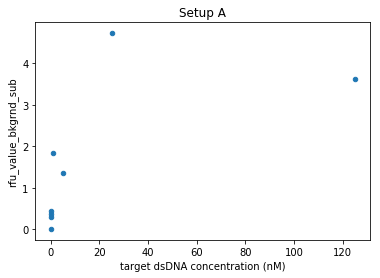

In [87]:
DETECTR_4hr.loc[DETECTR_4hr['Setup'] == 'A'].plot(x = 'target dsDNA concentration', y= 'rfu_value_bkgrnd_sub',title = 'Setup A (no gDNA background)',kind = 'scatter')
plt.xlabel('target dsDNA concentration (nM)')

Text(0.5,0,'target dsDNA concentration (nM)')

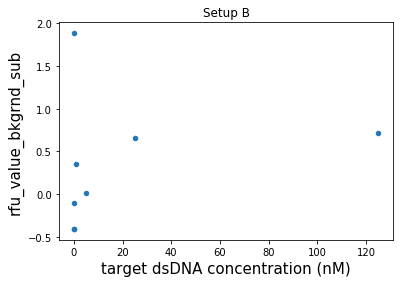

In [91]:
DETECTR_4hr.loc[DETECTR_4hr['Setup'] == 'B'].plot(x = 'target dsDNA concentration', y= 'rfu_value_bkgrnd_sub',title = 'Setup B (gDNA background constant at 616ng)',kind = 'scatter')
plt.xlabel('target dsDNA concentration (nM)')

Text(0.5,0,'target dsDNA concentration (nM)')

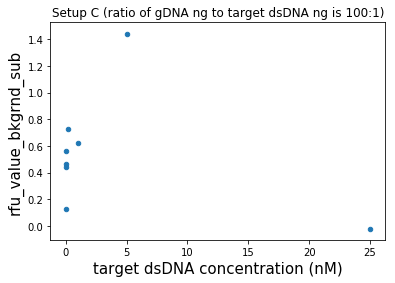

In [95]:
DETECTR_4hr.loc[DETECTR_4hr['Setup'] == 'C'].plot(x = 'target dsDNA concentration', y= 'rfu_value_bkgrnd_sub',title = 'Setup C (ratio of gDNA ng to target dsDNA ng is 100:1)',kind = 'scatter')
plt.xlabel('target dsDNA concentration (nM)')

Text(0.5,0,'target dsDNA concentration (nM)')

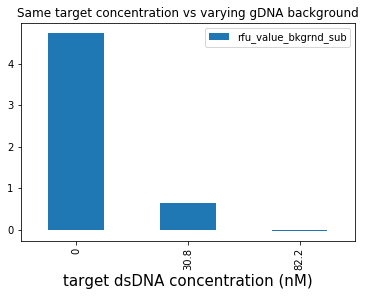

In [102]:
DETECTR_4hr.loc[DETECTR_4hr['target dsDNA concentration'] == 25].plot(x = 'Human gDNA concentration', y= 'rfu_value_bkgrnd_sub',title = 'Same target concentration vs varying gDNA background',kind = 'bar')
plt.xlabel('target dsDNA concentration (nM)')

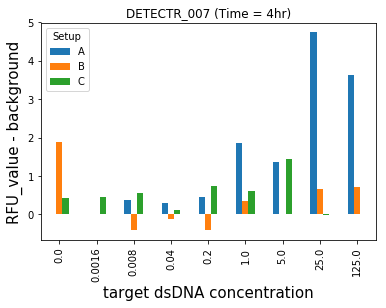

In [96]:
DETECTR_4hr.pivot('target dsDNA concentration', 'Setup','rfu_value_bkgrnd_sub').plot(kind = 'bar',)
plt.title ('DETECTR_007 (Time = 4hr)')
plt.ylabel('RFU_value - background')
plt.rc('font', size=10)
plt.rc('axes', labelsize=15)

plt.savefig("DETECTR_007.pdf", bbox_inches='tight')

## Conclusions
Adding genomic DNA background seemed to interfere with the ability to detect the target DNA. 
Note: this experiment seemed to have low signal anyway